In [1]:
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm
import cvxopt

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def dot(x,y):
    return np.sum(np.multiply(x,y))

In [58]:
en = 3
ch = 3
P = np.array([.2,.4,.4])
# P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
R = np.array([8.,6.,4.])
tol = .3
print(P)
print(E)
print(R)

[0.2 0.4 0.4]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[8. 6. 4.]


In [59]:
ub = np.sum(E*P,axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, dot(ltemp.x,ub))
org_x = ltemp.x
print(ltemp.x)

6.666666666666666 1.0 [0.] True 0.3
[0.33333333 0.66666667 0.        ]


In [60]:
print(en,ch,tol,np.dot(ltemp.x,R),min(ub))
print(P)
print(E)
print(ltemp.x)

3 3 0.3 6.666666666666666 0.2
[0.2 0.4 0.4]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[0.33333333 0.66666667 0.        ]


In [64]:
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0], bounds=(.08,1.0),method='revised simplex',options={'tol': 2.0e-1})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to make safe matrix dense 0.05
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(P)])
# yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
# yt = row_normalize([np.exp(yt)]).transpose()
# c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),np.max(np.matmul(x0.transpose(),E)),dot(x0.transpose(),R))

[0.09230769 0.81538462 0.09230769] 0.3461538461538462 6.000000000000001


In [55]:
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 1.0 # >= 1, ellipse radii
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1].transpose(),R)];c = [0.0]
b = []; enc = [];chnl = []
rate = []

In [56]:
def qclp_solver(A,C,x0,R,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    R = cvxopt.matrix(R)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1.0*R, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':False,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
# 'kktreg':1e-9, kktsolver='ldl','maxiters':30

In [57]:
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
for t in range(1,1000):
    enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    # yt = (E[enc[-1]]*(1-b[-1]))+((1-E[enc[-1]])*b[-1])
    # yt = row_normalize([np.exp(yt)]).transpose()
    r.append(dot(x[-1],R))
    c.append(1.0 - b[-1])  # c.append(dot(x[-1],np.matmul(E,yt)))
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    A = (((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans))
    betat = Ra*math.sqrt(en*math.log((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    d = -2*alfa_c*betat
    l = alfa_c*betat*(1+pow(dot(e0,e0),2.0))
    C = ((l*np.identity(en)) + (d*np.matmul(e0,e0_trans)))
    sol = qclp_solver(A,C,x0,R,en,tol)
    x.append(sol[0])
    rate.append(dot(x[-1].transpose(),R))
    print(t,rate[-1],sol[1],sum(x[-1]))
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(A,betat)

1 5.675104590495752 0.3500000090373653 [1.]
2 5.596938897385911 0.350000008005478 [1.]
3 5.583969381868708 0.35000000882698823 [1.]
4 5.498884904978359 0.3500000045236278 [1.]
5 5.501870075322165 0.35000000507105755 [1.]
6 5.504675495699794 0.3500000055472951 [1.]
7 5.466497972435007 0.3500000072319262 [1.]
8 5.470066052532259 0.3500000074057835 [1.]
9 5.4734098165679885 0.35000000756411376 [1.]
10 5.476528952899906 0.35000000771568107 [1.]
11 5.479430494123845 0.350000007865462 [1.]
12 5.482125217364808 0.35000000801620856 [1.]
13 5.459098539371522 0.35000000959741556 [1.]
14 5.44100190028672 0.35000001155238103 [1.]
15 5.443702388264008 0.35000001149490534 [1.]
16 5.42907749348458 0.3500000134954715 [1.]
17 5.431589939468087 0.3500000133892551 [1.]
18 5.434036300647524 0.35000001328392 [1.]
19 5.436415883472523 0.35000001318147567 [1.]
20 5.438728420268697 0.35000001308343276 [1.]
21 5.440974001050813 0.3500000129909008 [1.]
22 5.443153017113198 0.35000001290466953 [1.]
23 5.44526611

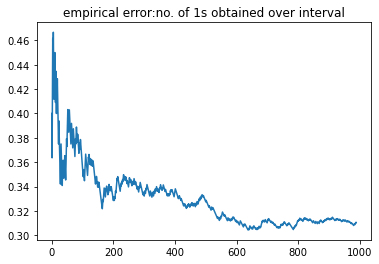

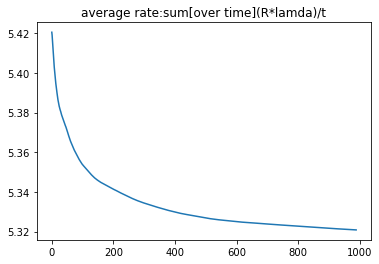

In [54]:
stat = 10
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [38]:
print(x0.flatten())
print(x[-1].flatten(),error_plot[-1],rate_plot[-1])
print(org_x,tol,dot(org_x,R))

[0.05454545 0.89090909 0.05454545]
[0.10625128 0.89090909 0.00283963] 0.24448897795591165 6.2127601220469
[0.33333333 0.66666667 0.        ] 0.3 6.666666666666666


18.367588191833065


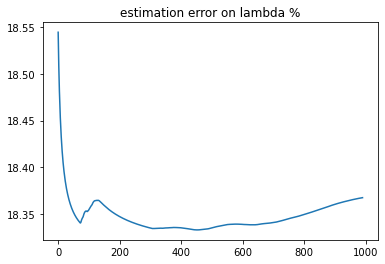

In [39]:
err = []
for i in range(len(x)):
    err.append(np.sqrt(np.sum(np.square(org_x-x[i].flatten()))/en)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err[stat:])
plt.title('estimation error on lambda %')
plt.show()

In [40]:
print(C)
print(A)
print(np.identity(en) - np.matmul(e0,e0_trans))
print(d,l)
print(dot(e0,e0))
print(x[-1])
print(x[0])

[[12.33934415 -0.75264879 -0.04608054]
 [-0.75264879  0.09216108 -0.75264879]
 [-0.04608054 -0.75264879 12.33934415]]
[[ 2.26062827e+00 -3.59455603e-13 -2.26062827e+00]]
[[ 0.99627945 -0.06076891 -0.00372055]
 [-0.06076891  0.00744109 -0.06076891]
 [-0.00372055 -0.06076891  0.99627945]]
-12.385424684216778 12.385424684216776
0.9999999999999999
[[0.10625128]
 [0.89090909]
 [0.00283963]]
[[0.05454545]
 [0.89090909]
 [0.05454545]]


In [41]:
y = np.array([0.1,0.9,0.])
print(np.matmul(A,y.transpose())+np.matmul(np.matmul(y,C),y.transpose()))
print(dot(y,R))

[0.28862996]
6.2


In [33]:
def qclp_solver(A,C,x0,R,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    R = cvxopt.matrix(R)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1.0*R, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]), options={'show_progress':True})
    print(sol['snl'])
    sol = sol['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
ans = qclp_solver(A,C,x0,R,en,tol)
print(ans)
print(dot(ans[0].transpose(),R))

     pcost       dcost       gap    pres   dres


TypeError: incompatible dimensions

In [ ]:
(Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/.1)/0.9))+math.sqrt(.1)*Sa)*linalg.norm(xopt) 

In [ ]:
alfa_c -> lamda error %
0.0 -> 0.7263980978187543
0.0001 -> 0.64
0.001 -> 0.17
0.005 -> 4

In [ ]:
import cvxopt
from cvxopt import matrix
def qclp_solver(A,C,x0,Rn,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    Rn = cvxopt.matrix(Rn)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1*Rn, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':True,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
a = matrix([[2.],[3.],[4.]])
b = matrix([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
c = matrix([[7.,9.,11.]])
x0 = matrix([[.9,.05,.05]])
p = qclp_solver(a,b,x0,R,3,3.5)
print(p)
print(c.trans()*matrix(p[0]))

In [ ]:
cvxopt.matrix(R),matrix([[7.,9.,11.]])

In [ ]:
a*x0

In [ ]:
a = matrix([[2.],[3.]])
b = matrix([[1.,2.],[2.,1.]])
c = matrix([[6.],[4.]])
tol = 5
A = matrix([1.0]*2).trans()
def F(x = None, z = None):
    if x is None:  return 1, matrix([[1.,0.]])
    if max(x) > 1.0 or min(x) < 0: return (None,None)
    f = (a*x) +  x.trans()*b*x - tol
    df = a + (2*b*x).trans()
    if z is None: return (f,df)
    h = 2*z*b
    return (f,df,h)

In [ ]:
print(sol['x'])
x = sol['x']
print((a*x) +  x.trans()*b*x - tol)
print(-1*c.trans()*x)

In [ ]:
matrix(np.array([[2.],[3.]])), matrix([[2.],[3.]])

In [ ]:
m = matrix([[1.0]])
print(m - tol, m - matrix([[.2]]))